# Создание GIF с появлением городов

In [1]:
import pandas as pd
from tqdm import tqdm

import gmplot
import os
from PIL import Image, ImageFont, ImageDraw

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

from pylab import rcParams
rcParams['figure.figsize'] = 18, 12

In [2]:
df = pd.read_pickle('cities.pkl')

# Простая статистика

''

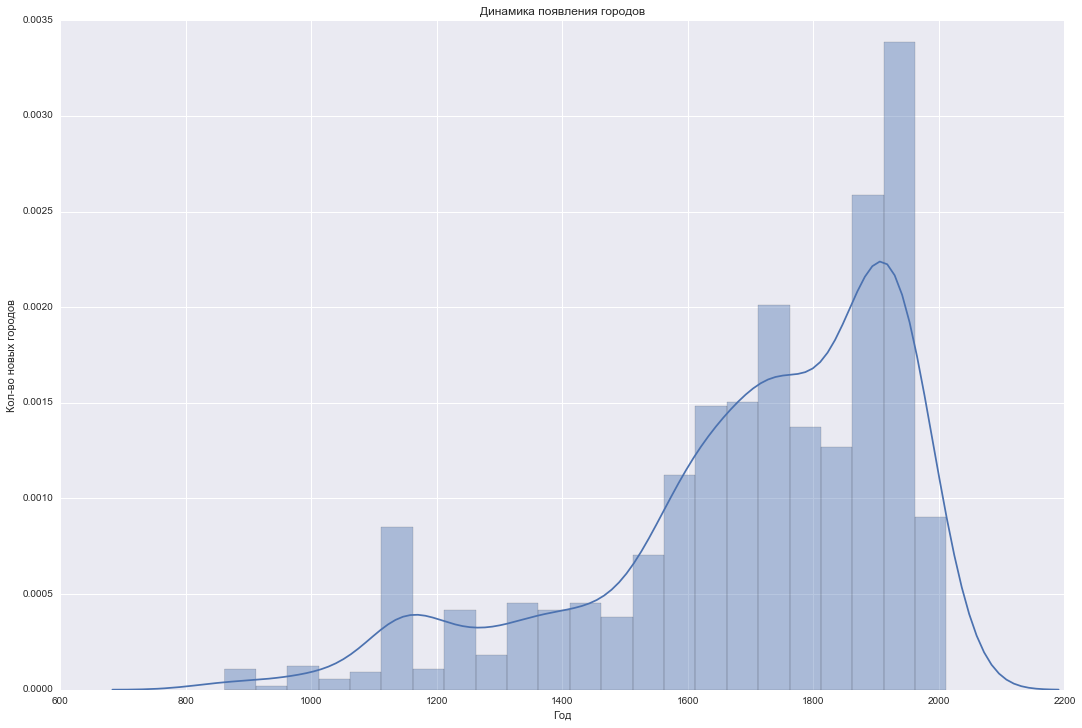

In [7]:
sns.distplot(df.year_appr[(df.year_appr>800)&(df.year_appr<2100)], bins = 23)
plt.title('Динамика появления городов')
plt.xlabel('Год')
plt.ylabel('Кол-во новых городов')
''

''

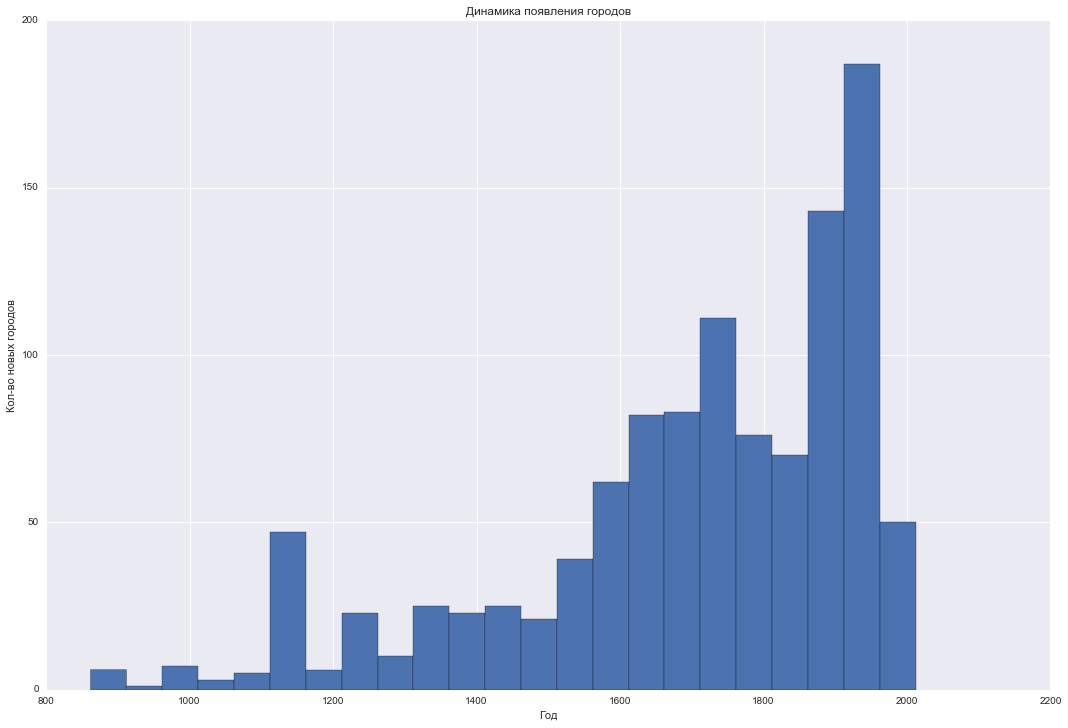

In [8]:
df.year_appr[(df.year_appr>800)&(df.year_appr<2100)].hist(bins = 23)
plt.title('Динамика появления городов')
plt.xlabel('Год')
plt.ylabel('Кол-во новых городов')
''

''

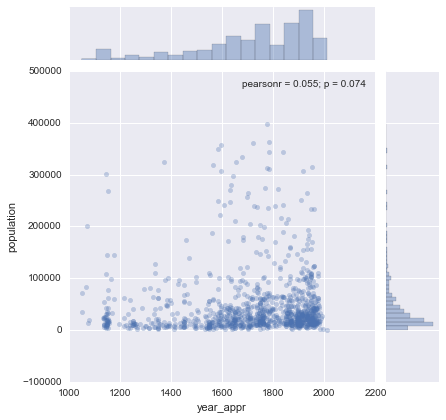

In [9]:
sns.jointplot('year_appr', 'population', data=df[(df.population<400000)&(df.year_appr>1000)], alpha=0.3)
''

последние города

In [10]:
df.sort_values(by='year_appr', ascending=False).head(10)

,city,region,fo,population,year,year_appr,lat,lon
339,Иннополис,Татарстан,Приволжский,96,2012,2012,48.744609,55.752080
548,Магас,Ингушетия,Северо-Кавказский,2505,1995,1995,44.804840,43.166669
762,Полысаево,Кемеровская область,Сибирский,27624,1989,1989,86.280901,54.605443
226,Губкинский,Ямало-Ненецкий АО,Уральский,23340,1986,1986,76.500494,64.432625
757,Покачи,Ханты-Мансийский АО — Югра,Уральский,17053,1984,1984,75.594120,61.742253
602,Муравленко,Ямало-Ненецкий АО,Уральский,33401,1984,1984,74.494448,63.795285
392,Кедровый,Томская область,Сибирский,2451,1982,1982,79.562590,57.564285
4,Агидель,Башкортостан,Приволжский,16365,1980,1980,53.922040,55.899835
514,Лангепас,Ханты-Мансийский АО — Югра,Уральский,41675,1980,1980,75.180725,61.253701
311,Заринск,Алтайский край,Сибирский,47035,1979,1979,84.931488,53.706332


# Простой вариант визуализации

In [7]:
years = list(range(800, 2018, 10))
len(years)

122

In [8]:
def make_plot(df, year, filename=None, alpha=1):
    plt.scatter(df.lat, df.lon, alpha=alpha)
    plt.xlim(0, 200)
    plt.ylim(35, 75)
    plt.title('Год {}'.format(year), fontsize=30)
    if filename:
        plt.savefig(filename)

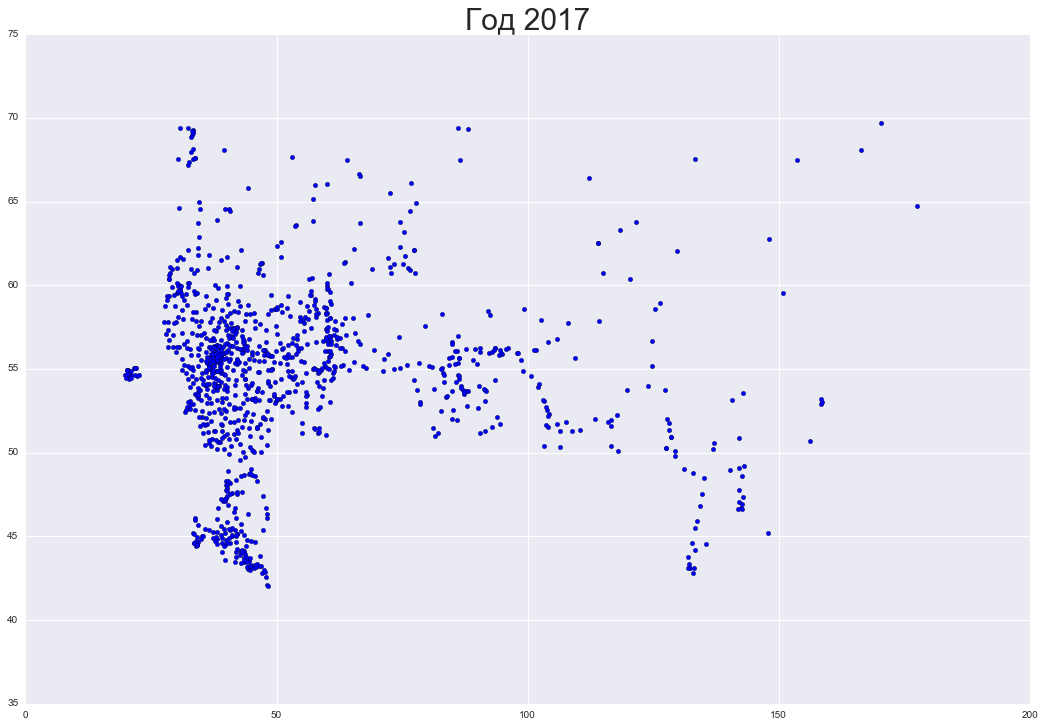

In [9]:
make_plot(df, 2017, alpha=1)

подсветим старые города насыщенными точками, новые - прозрачными

100%|██████████| 122/122 [00:00<00:00, 195.15it/s]


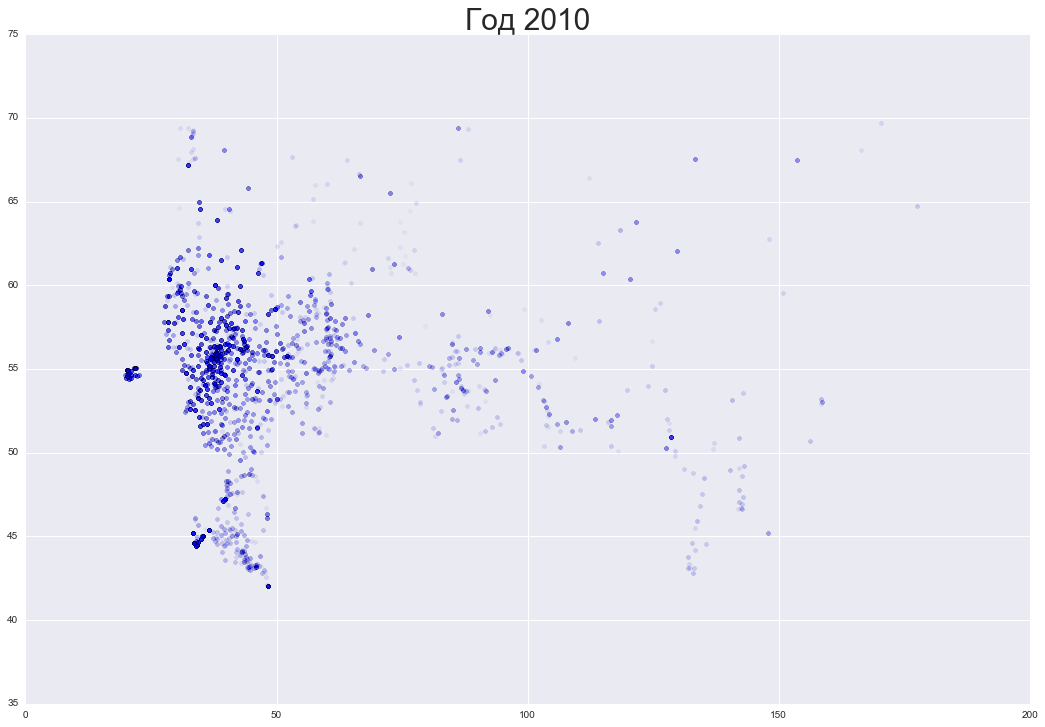

In [10]:
for year in tqdm(years):
    make_plot(df[df.year_appr<=year], year, alpha=0.01)

# Google Maps

наносим все города в отдельные google-карты в виде html-файлов

In [11]:
def rewrite_empty_dir(dir_name):
    if not dir_name.endswith('/'):
        dir_name += '/'
    try:
        for f in os.listdir(dir_name):
            os.remove(dir_name+f)
    except:
        os.mkdir(dir_name)

In [12]:
def make_map(df, filename, lat_center = 82.4709, lon_center = 61.5288):
    gmap = gmplot.GoogleMapPlotter(lon_center, lat_center, 4)
    gmap.scatter(mdf.lon, mdf.lat, marker=False, size=25000, color='darkred')
    gmap.draw(filename)

In [13]:
rewrite_empty_dir('html/')
for year in tqdm(years):
    mdf = df[df.year_appr<=year]
    year = "0{}".format(year)[-4:] #890->0890; 1890->1890 - понадобится, чтобы все файлы лежали по порядку
    make_map(mdf, "html/year{}.html".format(year))

100%|██████████| 122/122 [00:08<00:00,  3.27it/s]


# HTML 2 PNG

Конвертируем в png. Сделал так: с помощью простого bash-скрипта открываю через Safari кажды .html - файл, жду 3 секунды, делаю скрин. Из минусов: ничего нельзя делать в этого время и не параллелится, как следствие - простой 3*N секунды, N-число снимков. 0.2 секунды сна нужно, чтобы открытие следующего файла не пошло раньше завершения скриншота предыдущего 

*не забудьте заранее убрать мышку с карты =)*

In [14]:
pwd

'/Users/nikitakuznetsov/Documents/git_personal/Cities_Russia'

In [15]:
%%bash
for t in /Users/nikitakuznetsov/Documents/git_personal/Cities_Russia/html/*.html;
do
 open -a "Safari" $t
 sleep 3
 screencapture ${t%.html}.png;
 sleep 0.2
done

# PNG Crop + PNG Title

обрезаем png и наносим подписи

In [16]:
def crop(img):
    return img.crop((0, 85, 1440, 895))

def place_text(img, text):
    draw = ImageDraw.Draw(img)
    font = ImageFont.truetype("/Users/nikitakuznetsov/Documents/PFBeauSansPro/PFBeauSansPro-Black.ttf", 80)
    draw.text((240,20), text, (30, 30, 30), font=font)
    return img

In [18]:
output_png_folder = 'html_cut/'
input_png_folder = 'html/'
image_names = [f for f in os.listdir(input_png_folder) if f.endswith('.png')]

rewrite_empty_dir(output_png_folder)

for img_name, year in tqdm(zip(image_names, years)):
    img = Image.open(input_png_folder+img_name)   
    img = crop(img)
    img = place_text(img, text="Города {}".format(year))
    img.save(output_png_folder+img_name)

122it [00:57,  2.13it/s]


# PNG 2 GIF

In [19]:
def get_bash_code(folder, output_filename, delay, last_delay = None, optimize=False):
    optimize_str = " -layers Optimize" if optimize else ""
    last_delay = last_delay or delay

    if last_delay == delay:
        return "convert -delay {} {}/*.png{} {}".format(delay, folder, optimize_str, output_filename)

    filenames = [folder+f for f in os.listdir(folder) if f.endswith('.png')]
    return "convert {} {}{} {}".format(
        " ".join(["-delay {} {}".format(delay, filename) for filename in filenames[:-1]]),
        "-delay {} {}".format(last_delay, filenames[-1]),
        optimize_str,
        output_filename
    )

In [20]:
get_bash_code("html_cut/", "html_cities.gif", delay=20, last_delay=1500, optimize=True)

'convert -delay 20 html_cut/year0800.png -delay 20 html_cut/year0810.png -delay 20 html_cut/year0820.png -delay 20 html_cut/year0830.png -delay 20 html_cut/year0840.png -delay 20 html_cut/year0850.png -delay 20 html_cut/year0860.png -delay 20 html_cut/year0870.png -delay 20 html_cut/year0880.png -delay 20 html_cut/year0890.png -delay 20 html_cut/year0900.png -delay 20 html_cut/year0910.png -delay 20 html_cut/year0920.png -delay 20 html_cut/year0930.png -delay 20 html_cut/year0940.png -delay 20 html_cut/year0950.png -delay 20 html_cut/year0960.png -delay 20 html_cut/year0970.png -delay 20 html_cut/year0980.png -delay 20 html_cut/year0990.png -delay 20 html_cut/year1000.png -delay 20 html_cut/year1010.png -delay 20 html_cut/year1020.png -delay 20 html_cut/year1030.png -delay 20 html_cut/year1040.png -delay 20 html_cut/year1050.png -delay 20 html_cut/year1060.png -delay 20 html_cut/year1070.png -delay 20 html_cut/year1080.png -delay 20 html_cut/year1090.png -delay 20 html_cut/year1100.png

In [21]:
%%bash
convert -delay 20 html_cut/year0800.png -delay 20 html_cut/year0810.png -delay 20 html_cut/year0820.png -delay 20 html_cut/year0830.png -delay 20 html_cut/year0840.png -delay 20 html_cut/year0850.png -delay 20 html_cut/year0860.png -delay 20 html_cut/year0870.png -delay 20 html_cut/year0880.png -delay 20 html_cut/year0890.png -delay 20 html_cut/year0900.png -delay 20 html_cut/year0910.png -delay 20 html_cut/year0920.png -delay 20 html_cut/year0930.png -delay 20 html_cut/year0940.png -delay 20 html_cut/year0950.png -delay 20 html_cut/year0960.png -delay 20 html_cut/year0970.png -delay 20 html_cut/year0980.png -delay 20 html_cut/year0990.png -delay 20 html_cut/year1000.png -delay 20 html_cut/year1010.png -delay 20 html_cut/year1020.png -delay 20 html_cut/year1030.png -delay 20 html_cut/year1040.png -delay 20 html_cut/year1050.png -delay 20 html_cut/year1060.png -delay 20 html_cut/year1070.png -delay 20 html_cut/year1080.png -delay 20 html_cut/year1090.png -delay 20 html_cut/year1100.png -delay 20 html_cut/year1110.png -delay 20 html_cut/year1120.png -delay 20 html_cut/year1130.png -delay 20 html_cut/year1140.png -delay 20 html_cut/year1150.png -delay 20 html_cut/year1160.png -delay 20 html_cut/year1170.png -delay 20 html_cut/year1180.png -delay 20 html_cut/year1190.png -delay 20 html_cut/year1200.png -delay 20 html_cut/year1210.png -delay 20 html_cut/year1220.png -delay 20 html_cut/year1230.png -delay 20 html_cut/year1240.png -delay 20 html_cut/year1250.png -delay 20 html_cut/year1260.png -delay 20 html_cut/year1270.png -delay 20 html_cut/year1280.png -delay 20 html_cut/year1290.png -delay 20 html_cut/year1300.png -delay 20 html_cut/year1310.png -delay 20 html_cut/year1320.png -delay 20 html_cut/year1330.png -delay 20 html_cut/year1340.png -delay 20 html_cut/year1350.png -delay 20 html_cut/year1360.png -delay 20 html_cut/year1370.png -delay 20 html_cut/year1380.png -delay 20 html_cut/year1390.png -delay 20 html_cut/year1400.png -delay 20 html_cut/year1410.png -delay 20 html_cut/year1420.png -delay 20 html_cut/year1430.png -delay 20 html_cut/year1440.png -delay 20 html_cut/year1450.png -delay 20 html_cut/year1460.png -delay 20 html_cut/year1470.png -delay 20 html_cut/year1480.png -delay 20 html_cut/year1490.png -delay 20 html_cut/year1500.png -delay 20 html_cut/year1510.png -delay 20 html_cut/year1520.png -delay 20 html_cut/year1530.png -delay 20 html_cut/year1540.png -delay 20 html_cut/year1550.png -delay 20 html_cut/year1560.png -delay 20 html_cut/year1570.png -delay 20 html_cut/year1580.png -delay 20 html_cut/year1590.png -delay 20 html_cut/year1600.png -delay 20 html_cut/year1610.png -delay 20 html_cut/year1620.png -delay 20 html_cut/year1630.png -delay 20 html_cut/year1640.png -delay 20 html_cut/year1650.png -delay 20 html_cut/year1660.png -delay 20 html_cut/year1670.png -delay 20 html_cut/year1680.png -delay 20 html_cut/year1690.png -delay 20 html_cut/year1700.png -delay 20 html_cut/year1710.png -delay 20 html_cut/year1720.png -delay 20 html_cut/year1730.png -delay 20 html_cut/year1740.png -delay 20 html_cut/year1750.png -delay 20 html_cut/year1760.png -delay 20 html_cut/year1770.png -delay 20 html_cut/year1780.png -delay 20 html_cut/year1790.png -delay 20 html_cut/year1800.png -delay 20 html_cut/year1810.png -delay 20 html_cut/year1820.png -delay 20 html_cut/year1830.png -delay 20 html_cut/year1840.png -delay 20 html_cut/year1850.png -delay 20 html_cut/year1860.png -delay 20 html_cut/year1870.png -delay 20 html_cut/year1880.png -delay 20 html_cut/year1890.png -delay 20 html_cut/year1900.png -delay 20 html_cut/year1910.png -delay 20 html_cut/year1920.png -delay 20 html_cut/year1930.png -delay 20 html_cut/year1940.png -delay 20 html_cut/year1950.png -delay 20 html_cut/year1960.png -delay 20 html_cut/year1970.png -delay 20 html_cut/year1980.png -delay 20 html_cut/year1990.png -delay 20 html_cut/year2000.png -delay 1500 html_cut/year2010.png -layers Optimize html_cities.gif

-----